In [1]:
import numpy as np
rng = np.random.default_rng()
import polars as pl

# The Problem:

Given a random forest model, we want to find a good choice for the n_estimator parameter.

We are going to subsample on the feature space for each decision tree in the forest. 

Let's say we have 100 features in total. And we are subsampling 60 features for each decision tree. Ignore depth for now. How many estimators do we need so that we have 99% confidence that each feature is selected at least 3 times? (by different trees)

In [2]:
def generate_feature_counts(n_estimators:int, n_features:int) -> np.ndarray:
    pool = []

    for _ in range(n_estimators):
        feat = np.arange(100) 
        rng.shuffle(feat)
        choice = feat < n_features
        pool.append(choice)

    return np.array(pool).sum(axis=0)

In [7]:
# Monte Carlo
def money_carlo(n_trials:int, n_estimators:int, n_features:int, n_times:int) -> float:
    count = 0
    for _ in range(n_trials):
        trial = generate_feature_counts(n_estimators, n_features)
        if (trial >= n_times).sum() == len(trial):
            count += 1

    return count / n_trials

In [8]:
prob = 0.
n_estimators = 0
n_times = 3
n_trials = 500
n_features = 60

while prob < 0.99:
    n_estimators += 1
    prob = money_carlo(n_trials=n_trials, n_estimators=n_estimators, n_features=n_features, n_times=n_times)

print(f"We need {n_estimators} estimators to have 99% confidence that all features are considered at least {n_times} times.")

We need 17 estimators to have 99% confidence that all features are considered at least 3 times.


In [ ]:
trial = generate_feature_counts(n_estimators=17, n_features=60)

In [10]:
n_trials = 1000

sample = []
for _ in range(n_trials):
    trial = generate_feature_counts(17, 60)
    sample.append(trial)

all_samples = np.array(sample).ravel()
all_samples


array([10,  7,  8, ...,  9, 10, 10])

In [11]:
test_result = pl.from_records(all_samples, schema=["trial_result"]).groupby("trial_result").agg((
    pl.count(),
)).sort(by="trial_result").with_columns(
    (pl.col("count") / n_trials).alias("average_count")
)

In [12]:
# Average count is the average number of times a feature is selected
# The distribution of this average follows the normal distribution, which is
# the CLT.
test_result

trial_result,count,average_count
i32,u32,f64
1,1,0.001
2,9,0.009
3,40,0.04
4,199,0.199
5,774,0.774
6,2433,2.433
7,5638,5.638
8,10780,10.78
9,15975,15.975


In [13]:
import matplotlib.pyplot as plt

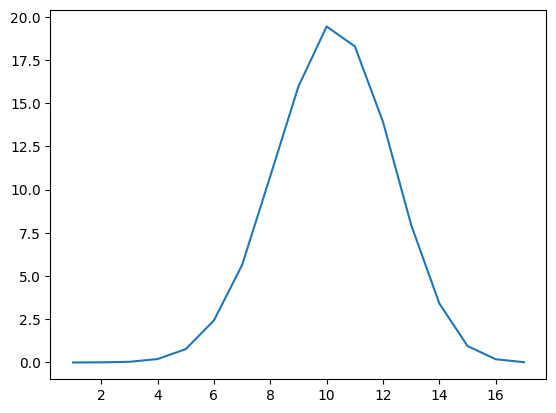

In [14]:
plt.plot(test_result["trial_result"], test_result['average_count'])